# Project

In [1]:
# import catboost as cb
from collections import Counter
# from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import mord
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import xgboost as xgb
# from statsmodels.graphics.regressionplots import plot_regress_exog

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
path = 'review-Alaska_10.json'

data_raw = pd.read_json(path, lines=True, encoding='utf-8')

invalid value encountered in cast


This indicates the presence of NA values in the data. However, as this is one of the aspects we intend to investigate, we will selectively perform data cleaning at a later stage.

In [3]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  521515 non-null  float64
 1   name     521515 non-null  object 
 2   time     521515 non-null  int64  
 3   rating   521515 non-null  int64  
 4   text     298257 non-null  object 
 5   pics     20851 non-null   object 
 6   resp     44232 non-null   object 
 7   gmap_id  521515 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.8+ MB
None


In [4]:
print(data_raw.head())

        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b6

## Data Dictionary

- index: The index of the data.
- user_id: The ID of the reviewer.
- name: The name of the reviewer.
- time: The time of the review in Unix time format.
- rating: The rating given by the reviewer for the business.
- text: The text of the review.
- pics: Pictures associated with the review.
- resp: The business response to the review, including Unix time and the text of the response.
- gmap_id: The ID of the business.

Due to the nature of our research topic, which is to explore the influence of time of day on online ratings across different devices, we will be selecting specific data variables for further analysis. The data variables of interest include "time," "rating," and "pics." The reason for selecting "pics" is due to the unfortunate inability to obtain data directly related to device types in the comments. Therefore, we need to make a crucial assumption: 
**we assume that comments with pictures are uploaded using mobile devices, while comments without pictures are uploaded using non-mobile devices.**

## Exploratory Data Analysis (EDA)



In this section, we will perform data preprocessing, which includes data cleaning and data transformation. Data cleaning involves handling missing values, outliers, and inconsistencies in the dataset. Data transformation may involve converting the "pics" data into device type data, etc. These steps allow us to make use of the available information and derive meaningful insights from the dataset. 

In [5]:
data_modified = (
    data_raw
    # Convert the timestamp to minutes since midnight
    .assign(minutes_since_midnight=lambda x: pd.to_datetime(x['time'], unit='ms', utc=True)
                                          .dt.tz_convert('America/Anchorage')
                                          .dt.hour * 60 
                                          + pd.to_datetime(x['time'], unit='ms', utc=True)
                                          .dt.tz_convert('America/Anchorage')
                                          .dt.minute)
    # device[0,1] represents ['Non-mobile devices', 'Mobile devices']
    .assign(device=lambda x: x['pics'].notnull().astype(int))
    # rating_binary[0,1] represents ['Rating not equal to 5', 'Rating equal to 5']
    .assign(rating_binary=lambda x: (x['rating'] == 5).astype(int))
    # length of text (words)
    .assign(text_length=lambda x: x['text'].apply(lambda t: len(t.split()) if t is not None else 0))
    # number of pics
    .assign(num_pics=lambda x: x['pics'].apply(lambda p: len(p) if isinstance(p, (list, pd.Series)) and p is not None else 0))
    # has_resp[0,1] represents ['No response', 'Has response']
    .assign(has_resp=lambda x: x['resp'].notnull().astype(int))
    .filter(['minutes_since_midnight', 'rating','rating_binary', 'device', 'text_length', 'num_pics', 'has_resp'])
).dropna()

print(data_modified[:10])


   minutes_since_midnight  rating  rating_binary  device  text_length  \
0                     732       5              1       0           30   
1                    1006       5              1       0           21   
2                    1031       4              0       0          137   
3                     922       4              0       0           61   
4                    1363       5              1       0           11   
5                     331       5              1       0           13   
6                    1167       5              1       1           22   
7                    1280       4              0       0           41   
8                    1196       2              0       0           25   
9                     728       3              0       0            3   

   num_pics  has_resp  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         0         0  
6         6         0  
7   

In [6]:
data_modified.isnull().sum()

minutes_since_midnight    0
rating                    0
rating_binary             0
device                    0
text_length               0
num_pics                  0
has_resp                  0
dtype: int64

In [7]:
data_modified.describe()

,minutes_since_midnight,rating,rating_binary,device,text_length,num_pics,has_resp
count,521515.000000,521515.000000,521515.000000,521515.000000,521515.000000,521515.000000,521515.000000
mean,882.249161,4.283750,0.572635,0.039982,11.605906,0.144485,0.084814
std,354.885456,1.035622,0.494696,0.195916,25.370924,1.310613,0.278606
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,652.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,931.000000,5.000000,1.000000,0.000000,3.000000,0.000000,0.000000
75%,1169.000000,5.000000,1.000000,0.000000,13.000000,0.000000,0.000000
max,1439.000000,5.000000,1.000000,1.000000,823.000000,50.000000,1.000000


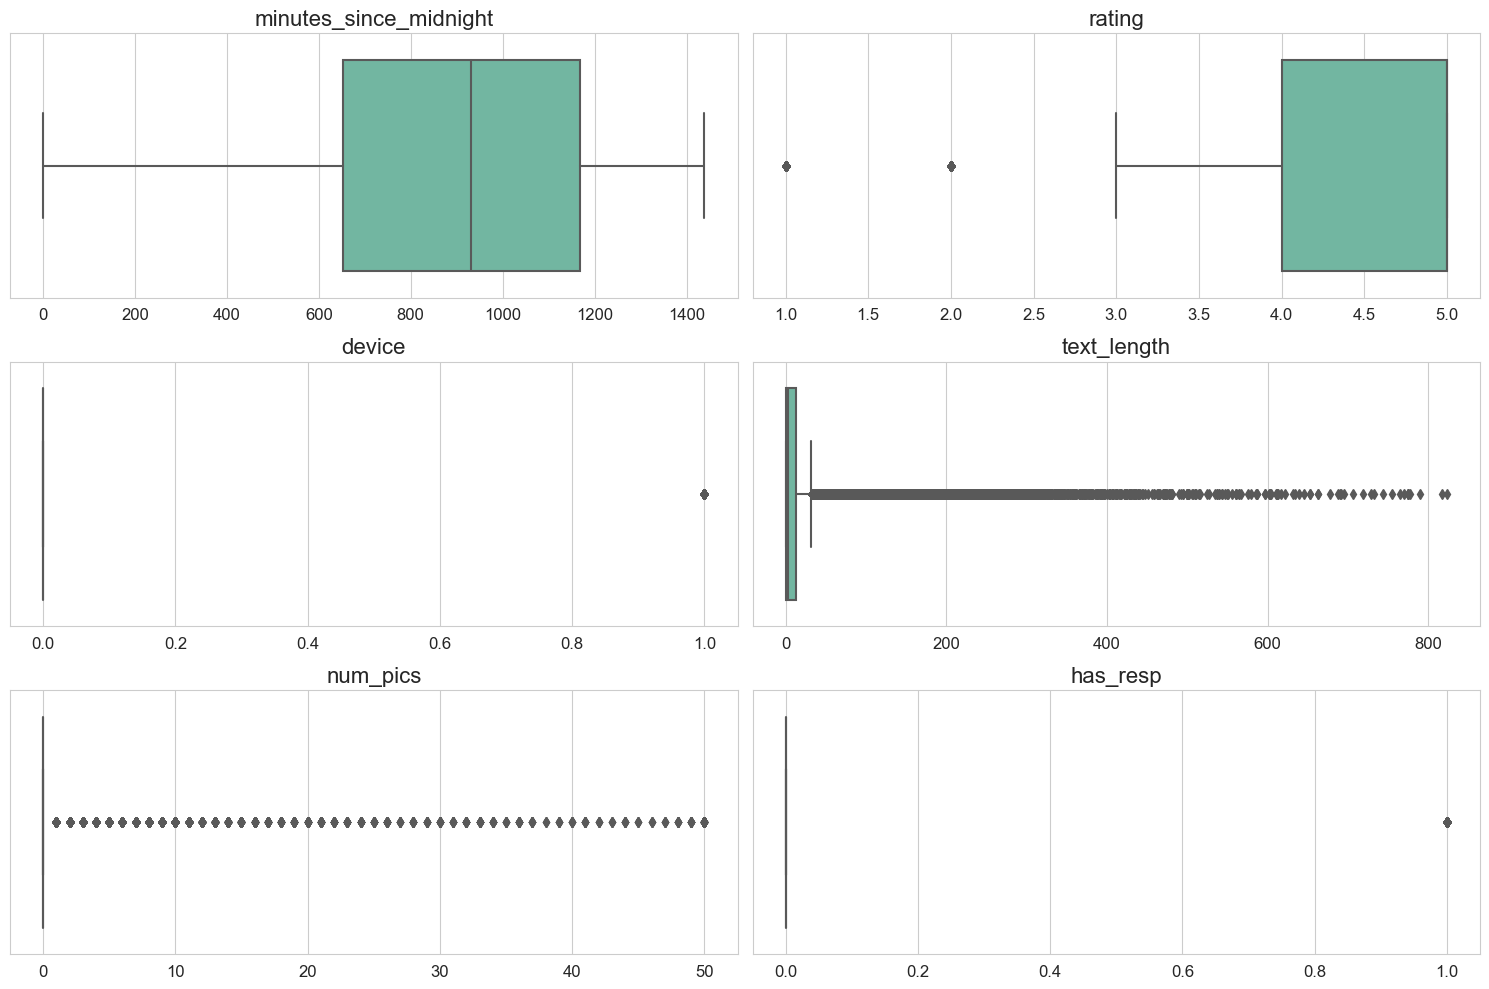

In [8]:
# Set the style to a more academic theme
sns.set_style("whitegrid")

# Drop the 'rating_binary' column for this visualization
data_to_plot = data_modified.drop('rating_binary', axis=1)

# Number of rows and columns for the subplot
nrows = 3
ncols = 2

# Create a larger figure based on the number of features
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Loop through each feature and plot a boxplot
for idx, column in enumerate(data_to_plot.columns):
    row = idx // ncols
    col = idx % ncols
    sns.boxplot(data=data_to_plot, x=column, ax=axes[row, col], palette="Set2")
    axes[row, col].set_title(f'{column}', fontsize=16)
    axes[row, col].set_xlabel('')
    axes[row, col].tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
def get_outliers(data, column):
    # Calculate Q1, Q3 and IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data for outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    return outliers

# Check outliers for 'text_length'
outliers_text_length = get_outliers(data_modified, 'text_length')

print("Outliers for text_length:")
print(outliers_text_length)


Outliers for text_length:
        minutes_since_midnight  rating  rating_binary  device  text_length  \
2                         1031       4              0       0          137   
3                          922       4              0       0           61   
7                         1280       4              0       0           41   
14                        1318       5              1       0           63   
16                         479       5              1       0           37   
...                        ...     ...            ...     ...          ...   
521299                     715       4              0       0           64   
521339                    1140       2              0       0           35   
521344                    1310       3              0       0           36   
521347                     971       3              0       0           35   
521349                     590       3              0       0           42   

        num_pics  has_resp  
2       

In [10]:
# Check outliers for 'num_pics'
outliers_num_pics = get_outliers(data_modified, 'num_pics')

print("Outliers for num_pics:")
print(outliers_num_pics)

Outliers for num_pics:
        minutes_since_midnight  rating  rating_binary  device  text_length  \
6                         1167       5              1       1           22   
77                        1299       5              1       1            1   
83                        1055       5              1       1           27   
89                         595       5              1       1            9   
103                        477       5              1       1            6   
...                        ...     ...            ...     ...          ...   
521295                     496       5              1       1           32   
521297                    1312       5              1       1           10   
521298                     419       5              1       1           45   
521313                     364       5              1       1            4   
521384                     881       3              0       1            2   

        num_pics  has_resp  
6          

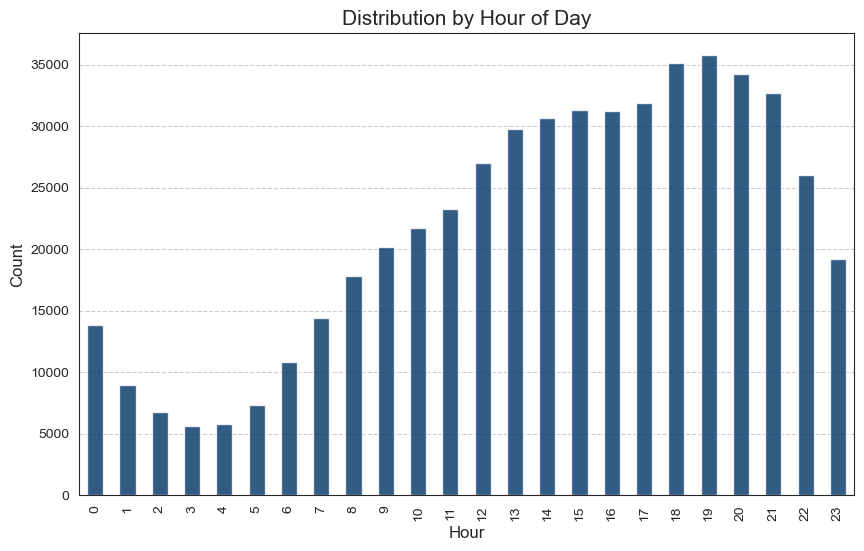

In [60]:
# Set the color palette and style
sns.set_style("white")

plt.figure(figsize=(10,6))
(data_modified['minutes_since_midnight'] // 60).value_counts().sort_index().plot(kind='bar', alpha=0.8, color="#003366")
plt.title('Distribution by Hour of Day', fontsize=15)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.show()

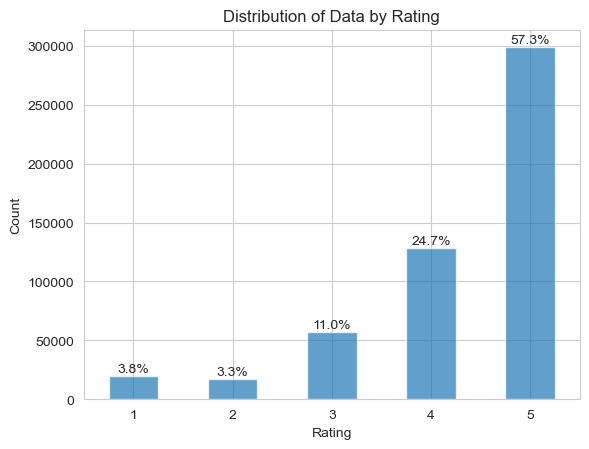

In [12]:
# Histogram for data distribution by rating
counts = data_modified['rating'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

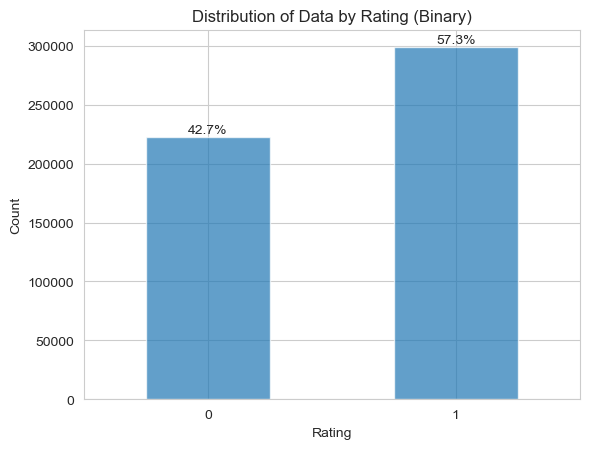

In [13]:
# Histogram for data distribution by rating
counts = data_modified['rating_binary'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating (Binary)')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

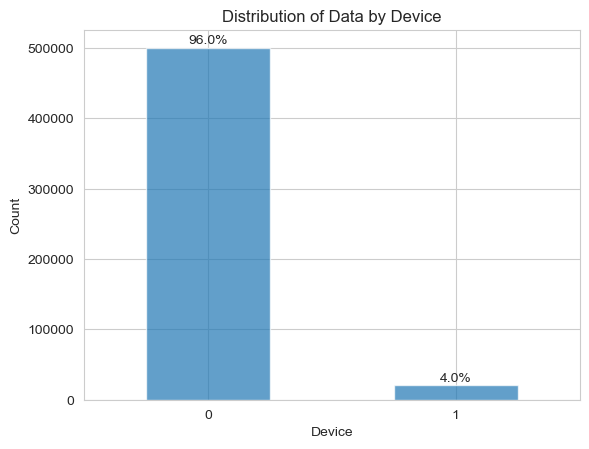

In [14]:
# Histogram for data distribution by devices
counts = data_modified['device'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Device')
plt.ylabel('Count')
plt.title('Distribution of Data by Device')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

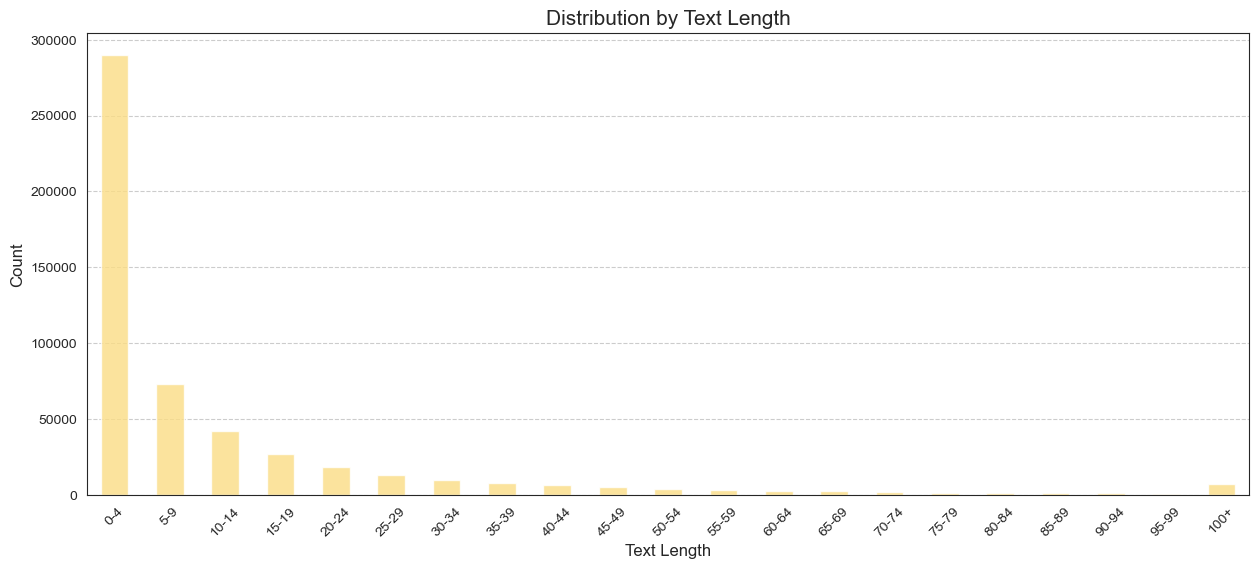

In [61]:
# Define the bin range for text_length
bins_text = list(range(0, 101, 5)) + [data_modified['text_length'].max() + 1]

# Labels for the bins
labels = [f"{bins_text[i]}-{bins_text[i+1]-1}" for i in range(len(bins_text)-2)] + ["100+"]

# Bin the text_length
data_modified['text_length_binned'] = pd.cut(data_modified['text_length'], bins=bins_text, right=False, labels=labels)

# Count the number of records in each bin
counts_text = data_modified['text_length_binned'].value_counts().sort_index()

# Plot
plt.figure(figsize=(15, 6))
counts_text.plot(kind='bar', alpha=0.8, color="#FBDD85")
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution by Text Length', fontsize=15)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--')
plt.show()


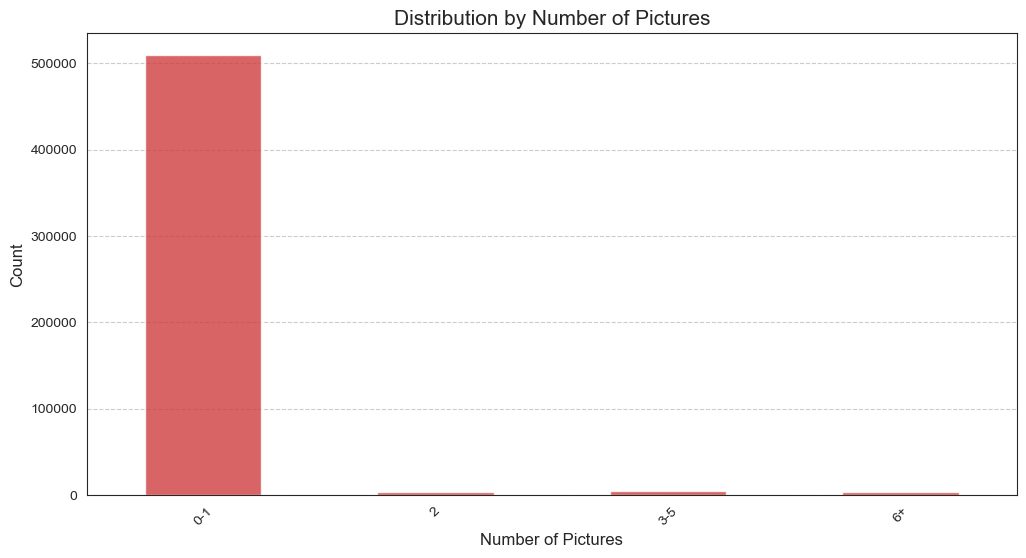

In [62]:
# Histogram for data distribution by num_pics
max_pics = 5  
data_modified['num_pics_binned'] = pd.cut(data_modified['num_pics'], bins=[-1, 1, 2, max_pics, data_modified['num_pics'].max()], labels=['0-1', '2', '3-'+str(max_pics), str(max_pics+1)+'+'])
counts_pics = data_modified['num_pics_binned'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
counts_pics.plot(kind='bar', alpha=0.8, color="#CF3D3E")  # Using a brighter color from the Set2 palette
plt.xlabel('Number of Pictures', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution by Number of Pictures', fontsize=15)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--')
plt.show()


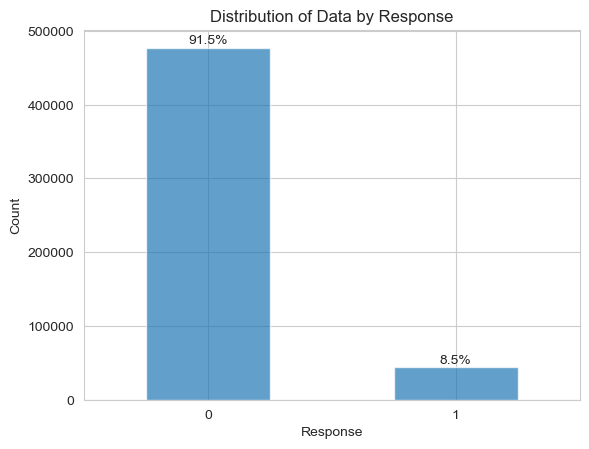

In [17]:
# Histogram for data distribution by has_resp
counts = data_modified['has_resp'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Data by Response')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

In [18]:
data_modified = data_modified.filter(['minutes_since_midnight', 'rating', 'rating_binary' , 'device', 'text_length', 'num_pics', 'has_resp'])
print(data_modified.isnull().sum())

minutes_since_midnight    0
rating                    0
rating_binary             0
device                    0
text_length               0
num_pics                  0
has_resp                  0
dtype: int64


### Relationships

In [ ]:
columns_to_plot = ['minutes_since_midnight', 'device', 'text_length', 'num_pics', 'has_resp']

# Create subplots for each column and for both 'rating' and 'rating_binary'
fig, axs = plt.subplots(len(columns_to_plot), 2, figsize=(15, 5*len(columns_to_plot)))

# For each column in the list
for i, col in enumerate(columns_to_plot):
    
    # Bar plot for 'rating'
    sns.barplot(x=col, y='rating', data=data_modified, ax=axs[i, 0], errorbar=None)
    axs[i, 0].set_title(f'Mean Rating by {col}')
    
    # Simplify x-axis labels if too many unique values
    if len(data_modified[col].unique()) > 20:
        ticks = axs[i, 0].get_xticks()
        visible_ticks = ticks[::5]  # Show every 5th tick
        axs[i, 0].set_xticks(visible_ticks)
        axs[i, 0].set_xticklabels(data_modified[col].unique()[::5])
    
    # Bar plot for 'rating_binary'
    sns.barplot(x=col, y='rating_binary', data=data_modified, ax=axs[i, 1], errorbar=None)
    axs[i, 1].set_title(f'Mean Rating Binary by {col}')
    
    # Simplify x-axis labels if too many unique values
    if len(data_modified[col].unique()) > 20:
        ticks = axs[i, 1].get_xticks()
        visible_ticks = ticks[::5]  # Show every 5th tick
        axs[i, 1].set_xticks(visible_ticks)
        axs[i, 1].set_xticklabels(data_modified[col].unique()[::5])

plt.tight_layout()
plt.show()


#### minutes_since_midnight and rating

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Convert the timestamp to a readable date format with correct timezone
date = pd.to_datetime(data_raw['time'], unit='ms', utc=True).dt.tz_convert('America/Anchorage')
year = date.dt.year

# Plotting the average rating per year
sns.pointplot(x=year, y=data_modified['rating'], ax=ax1, order=sorted(year.unique()), color='salmon', errorbar=None)

# Plotting the number of reviews per year
sns.countplot(x=year, ax=ax2, order=sorted(year.unique()), color='skyblue')

# Setting the y axis labels
ax1.set_ylabel('Average Rating', color='red')
ax2.set_ylabel('Number of Reviews', color='blue')

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

plt.title('Number of Reviews and Average Rating per Year')
plt.show()


In [ ]:
from scipy.signal import savgol_filter

# Grouping by minutes_since_midnight and calculating the average rating
average_ratings = data_modified.groupby('minutes_since_midnight')['rating'].mean().reset_index()

# Apply Savitzky-Golay filter for smoothing
average_ratings['smoothed'] = savgol_filter(average_ratings['rating'], 51, 3)  # window size 51, polynomial order 3

# Plotting the average rating throughout the day
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_ratings, x='minutes_since_midnight', y='rating', color="salmon", label="Average Rating")
sns.lineplot(data=average_ratings, x='minutes_since_midnight', y='smoothed', color="blue", label="Smoothed Rating")

plt.title('Average Rating Throughout the Day')
plt.xlabel('Minutes Since Midnight')
plt.ylabel('Average Rating')
plt.legend()
plt.show()


In [ ]:
# Grouping by minutes_since_midnight and calculating the average rating
average_ratings = data_modified.groupby('minutes_since_midnight')['rating'].mean().reset_index()

# Plotting the average rating throughout the day
plt.figure(figsize=(12, 6))

# Base line
sns.lineplot(data=average_ratings, x='minutes_since_midnight', y='rating', color="salmon", label="Average Rating")

# Adding a smoothed regression fit line
sns.regplot(data=average_ratings, x='minutes_since_midnight', y='rating', scatter=False, lowess=True, color="blue", label="Smoothed Fit")

plt.title('Average Rating Throughout the Day')
plt.xlabel('Minutes Since Midnight')
plt.ylabel('Average Rating')
plt.legend()
plt.show()


#### device and rating

In [ ]:
# KDE plot showing distribution of ratings based on device type
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data_modified[data_modified['device'] == 0]['rating'], label="Non-mobile devices", fill=True)
sns.kdeplot(data=data_modified[data_modified['device'] == 1]['rating'], label="Mobile devices", fill=True)
plt.title('Distribution of Ratings Based on Device Type')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.show()


#### text length and rating

In [ ]:
# Plotting the boxplot for text_length vs rating
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_modified, x='rating', y='text_length', palette="pastel")
plt.title('Boxplot of Text Length vs Rating')
plt.ylim(0, 1000)  # Limiting y-axis for a clearer view
plt.show()


#### number of pics and rating

In [ ]:
# Plotting a boxplot to show the distribution of pic count for each rating
plt.figure(figsize=(12, 6))
data_modified.boxplot(column='num_pics', by='rating', grid=False, vert=False, patch_artist=True)
plt.title('Distribution of Picture Count by Rating')
plt.xlabel('Picture Count')
plt.ylabel('Rating')
plt.suptitle('')  # Suppress the default suptitle
plt.tight_layout()

plt.show()

#### has_resp and rating

In [ ]:
# Plotting the Count of reviews by rating and response status with rating on y-axis
plt.figure(figsize=(10, 6))
sns.countplot(data=data_modified, y='rating', hue='has_resp', palette="pastel")
plt.title('Count of Reviews by Rating and Response Status')
plt.ylabel('Rating')
plt.xlabel('Number of Reviews')
plt.legend(title='Has Response', labels=['No Response', 'Has Response'])
plt.show()

In [ ]:
# # Plotting the boxplot for has_resp vs rating
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=data_modified, x='rating', y='has_resp', palette="pastel", orient="h")
# plt.title('Boxplot of Whether Merchant Responded vs Rating')
# plt.show()


### Pearson's Correlation Coefficient for Continuous Variables with 'rating'

In [ ]:
# Defining the variable lists again
continuous_vars = ['minutes_since_midnight', 'text_length', 'num_pics']
categorical_vars = ['device', 'has_resp']

# Calculating Pearson's Correlation Coefficient for Continuous Variables with 'rating' again
pearson_correlations_rating = {}

for var in continuous_vars:
    corr, p_val = stats.pearsonr(data_modified[var], data_modified['rating'])
    pearson_correlations_rating[var] = (corr, p_val)

pearson_correlations_rating_df = pd.DataFrame(pearson_correlations_rating, 
                                              index=['Correlation', 'P-value']).T
pearson_correlations_rating_df


### Spearman's Rank Correlation Coefficient for Continuous Variables with 'rating'

In [ ]:
# Calculating Spearman's Rank Correlation Coefficient for Continuous Variables with 'rating'
spearman_correlations_rating = {}

for var in continuous_vars:
    corr, p_val = stats.spearmanr(data_modified[var], data_modified['rating'])
    spearman_correlations_rating[var] = (corr, p_val)

spearman_correlations_rating_df = pd.DataFrame(spearman_correlations_rating, 
                                               index=['Correlation', 'P-value']).T
spearman_correlations_rating_df


### Point-biserial Correlation Coefficient for Continuous Variables with 'rating_binary'

In [ ]:
# Calculating Point-biserial Correlation Coefficient for Continuous Variables with 'rating_binary'
pointbiserial_correlations_rating_binary = {}

for var in continuous_vars:
    corr, p_val = stats.pointbiserialr(data_modified[var], data_modified['rating_binary'])
    pointbiserial_correlations_rating_binary[var] = (corr, p_val)

pointbiserial_correlations_rating_binary_df = pd.DataFrame(pointbiserial_correlations_rating_binary, 
                                                           index=['Correlation', 'P-value']).T
pointbiserial_correlations_rating_binary_df


### Kruskal-Wallis H-test for Relationships between Categorical Variables and 'rating'

In [ ]:
# Calculating Kruskal-Wallis H-test for Relationships between Categorical Variables and 'rating'
kruskal_wallis_results = {}

for var in categorical_vars:
    statistic, p_val = stats.kruskal(*[data_modified['rating'][data_modified[var] == k] for k in data_modified[var].unique()])
    kruskal_wallis_results[var] = (statistic, p_val)

kruskal_wallis_df = pd.DataFrame(kruskal_wallis_results, 
                                 index=['Statistic', 'P-value']).T
kruskal_wallis_df


### Chi-squared Test of Independence for Associations between Categorical Variables and 'rating_binary'

In [ ]:
# Calculating Chi-squared Test of Independence for associations between Categorical Variables and 'rating_binary'
chi2_results = {}

for var in categorical_vars:
    contingency_table = pd.crosstab(data_modified[var], data_modified['rating_binary'])
    chi2_stat, p_val, _, _ = stats.chi2_contingency(contingency_table)
    chi2_results[var] = (chi2_stat, p_val)

chi2_df = pd.DataFrame(chi2_results, 
                       index=['Chi2 Statistic', 'P-value']).T
chi2_df


### Spearman Correlation

In [ ]:
# Identify continuous variables
continuous_vars = ['minutes_since_midnight', 'text_length', 'num_pics']

def detailed_spearman_correlation(data, cont_vars):
    results = []
    for var1 in cont_vars:
        for var2 in cont_vars:
            if var1 != var2:
                corr, p_val = stats.spearmanr(data[var1], data[var2])
                results.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Spearman Correlation': corr,
                    'P-value': p_val
                })
    return pd.DataFrame(results)

detailed_spearman_df = detailed_spearman_correlation(data_modified, continuous_vars)
detailed_spearman_df


### Multicollinearity test

In [ ]:
X = data_modified[['minutes_since_midnight', 'rating', 'rating_binary', 'device', 'text_length', 'num_pics', 'has_resp']]
vif_data = pd.DataFrame()
vif_data['Features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nMulticollinearity test:")
print(vif_data)

## Modeling

### Train and Test Sets

In [ ]:
# Separate features (X) and target variable (y) in the balanced dataset
X = data_modified.drop(['rating', 'rating_binary'], axis=1)
y = data_modified['rating']

X_bi = data_modified.drop(['rating', 'rating_binary'], axis=1)
y_bi = data_modified['rating_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2221877)


In [ ]:
# Split indices
train_idx, test_idx = train_test_split(data_modified.index, test_size=0.2, random_state=2221877)

# Use indices to extract training and testing data
X_train = data_modified.loc[train_idx].drop(['rating', 'rating_binary'], axis=1)
y_train = data_modified.loc[train_idx]['rating']

X_train_bi = data_modified.loc[train_idx].drop('rating', axis=1)
y_train_bi = data_modified.loc[train_idx]['rating_binary']

X_test = data_modified.loc[test_idx].drop(['rating', 'rating_binary'], axis=1)
y_test = data_modified.loc[test_idx]['rating']

X_test_bi = data_modified.loc[test_idx].drop('rating', axis=1)
y_test_bi = data_modified.loc[test_idx]['rating_binary']


### Data Balancing

It can be seen that there is a significant data imbalance between the different ratings. Having tried sampling and undersampling, I ended up combining them to try and get the most optimal sampling results to support my models.

In [ ]:
# Calculate the number of samples in each class
counter = Counter(y)
counter_bi = Counter(y_bi)

# Define the target sample numbers for over-sampling and under-sampling
max_samples = max(counter.values())
min_samples = min(counter.values())
max_samples_bi = max(counter_bi.values())
min_samples_bi = min(counter_bi.values())

# Define pipeline
over = SMOTE(sampling_strategy={class_label: max_samples for class_label in counter})
under = RandomUnderSampler(sampling_strategy={class_label: min_samples for class_label in counter})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

over_bi = SMOTE(sampling_strategy={class_label: max_samples_bi for class_label in counter_bi})
under_bi = RandomUnderSampler(sampling_strategy={class_label: min_samples_bi for class_label in counter_bi})
steps_bi = [('o', over_bi), ('u', under_bi)]
pipeline_bi = Pipeline(steps=steps_bi)

# Apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X, y)
X_resampled_bi, y_resampled_bi = pipeline_bi.fit_resample(X_bi, y_bi)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=2221877)
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_resampled_bi, y_resampled_bi, test_size=0.2, random_state=2221877)


In [ ]:
# Count samples for each class in 'rating' and 'rating_binary'
count_rating = Counter(y_resampled)
count_rating_bi = Counter(y_resampled_bi)

count_rating, count_rating_bi

### Decision Tree

In [ ]:
model_DT = DecisionTreeClassifier()

model_DT.fit(X_resampled, y_resampled)

predictions_DT = model_DT.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_DT))
print(classification_report(y_test, predictions_DT))

cm = confusion_matrix(y_test, predictions_DT)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Create an Explainer object
explainer_DT = shap.Explainer(model_DT)

# Calculate SHAP values
shap_values_DT = explainer_DT.shap_values(X_test)

# Visualise the first prediction's explanation
shap.summary_plot(shap_values_DT, X_test, plot_type="bar")

In [ ]:
def plot_multiclass_summary(shap_values_list, X_test, class_names=None, max_display=None):
    num_classes = len(shap_values_list)
    
    if max_display is None:
        max_display = num_classes
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]
    
    for i in range(max_display):
        shap_values_class = shap_values_list[i]
        class_name = class_names[i]
        
        # Display summary plot for the class
        shap.summary_plot(shap_values_class, X_test, show=False, plot_type='dot', title=class_name)
        plt.title(class_name)
        plt.show()
        
        # Print average SHAP values for each feature for the class
        print(f"\nAverage SHAP values for {class_name}:\n")
        shap_avg = np.abs(shap_values_class).mean(axis=0)
        for feature, value in zip(X_test.columns, shap_avg):
            print(f"{feature}: {value:.4f}")
        print("\n" + "="*50 + "\n")

In [ ]:
# Call the function with shap_values_DT and X_test
plot_multiclass_summary(shap_values_DT, X_test)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Using the Decision Tree model as an example, and targeting class 1
features = ['minutes_since_midnight', 'device', 'text_length', 'num_pics', 'has_resp']

# Create a larger figure
fig, ax = plt.subplots(len(features), 1, figsize=(8, len(features) * 4))

display = PartialDependenceDisplay.from_estimator(model_DT, X_test, features, target=1, ax=ax)

# Adjust layout for better visibility
fig.tight_layout(pad=3.0)

# Display the plots
plt.show()



In [ ]:
# Compute SHAP interaction values
shap_interaction_values = explainer_DT.shap_interaction_values(X_test)  # using a subset for visualization

# Just using the interaction values for the first class as an example
shap_values_class_0 = shap_interaction_values[0]

# Plot
shap.dependence_plot(
    ("minutes_since_midnight", "text_length"), 
    shap_values_class_0,
    X_test
)

In [ ]:
shap_interaction_values = explainer_DT.shap_interaction_values(X_test)

# Plotting interaction values for all features
shap.summary_plot(shap_interaction_values, X_test)


In [ ]:
model_DT_bi = DecisionTreeClassifier()

model_DT_bi.fit(X_resampled_bi, y_resampled_bi)

predictions_DT_bi = model_DT_bi.predict(X_test_bi)

print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_DT_bi))
print(classification_report(y_test_bi, predictions_DT_bi))

cm_bi = confusion_matrix(y_test_bi, predictions_DT_bi)
sns.heatmap(cm_bi, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Create an Explainer object
explainer_DT_bi = shap.Explainer(model_DT_bi)

# Calculate SHAP values
shap_values_DT_bi = explainer_DT_bi.shap_values(X_test_bi)

# Visualise the first prediction's explanation
shap.summary_plot(shap_values_DT_bi, X_test_bi)

In [ ]:
# Call the function with shap_values_DT_bi and X_test_bi
plot_multiclass_summary(shap_values_DT_bi, X_test_bi)

### Random Forest

In [ ]:
model_RF = RandomForestClassifier()

model_RF.fit(X_resampled, y_resampled)

predictions_RF = model_RF.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_RF))
print(classification_report(y_test, predictions_RF))

cm = confusion_matrix(y_test, predictions_RF)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model_RF_bi = RandomForestClassifier()

model_RF_bi.fit(X_resampled_bi, y_resampled_bi)

predictions_RF_bi = model_RF_bi.predict(X_test_bi)

print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_RF_bi))
print(classification_report(y_test_bi, predictions_RF_bi))

cm_bi = confusion_matrix(y_test_bi, predictions_RF_bi)
sns.heatmap(cm_bi, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Ordinal Logistic Regression

In [ ]:
import statsmodels.api as sm

y_dummies = pd.get_dummies(y_resampled)

# 1. 使用完整的有序逻辑回归模型拟合数据
model_full = sm.MNLogit(y_resampled, X_resampled)
result_full = model_full.fit()

# 2 & 3. 对于每个解释变量，创建交互项，然后拟合新模型
# 这里我们只为一个解释变量创建交互项作为示例，您可以为其他变量重复此过程
X_interacted = X_resampled.copy()
for col in X_resampled.columns:
    for dummy_col in y_dummies.columns:
        interaction_col_name = col + "_x_" + str(dummy_col)
        X_interacted[interaction_col_name] = X_resampled[col] * y_dummies[dummy_col]

model_interacted = sm.MNLogit(y_resampled, X_interacted)
result_interacted = model_interacted.fit()

# 4. 使用似然比检验
lr_stat = -2 * (result_full.llf - result_interacted.llf)
p_value = stats.chi2.sf(lr_stat, df=(X_interacted.shape[1] - X_resampled.shape[1]))

print(f"Likelihood ratio test statistic: {lr_stat}")
print(f"P-value: {p_value}")


In [ ]:
# Create an instance of the LogisticAT model
model_OL = mord.LogisticAT()

# Fit the model to the data
model_OL.fit(X_resampled, y_resampled)

# Use the model to make predictions
predictions_OL = model_OL.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_OL))
print(classification_report(y_test, predictions_OL))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions_OL)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### XGBoost

In [ ]:
# Create an XGBoost classifier
model_XGB = xgb.XGBClassifier()

# Adjust labels for XGBoost
y_resampled_adjusted = y_resampled - 1
y_test_adjusted = y_test - 1

# Fit the model to the data
model_XGB.fit(X_resampled, y_resampled_adjusted)

# Make predictions
predictions_XGB = model_XGB.predict(X_test)

# Revert the predictions to the original scale
predictions_XGB = predictions_XGB + 1

# Evaluate the model's performance
print('Accuracy score (XGBoost): ', balanced_accuracy_score(y_test, predictions_XGB))
print(classification_report(y_test, predictions_XGB))

# Plot the confusion matrix
cm_XGB = confusion_matrix(y_test, predictions_XGB)
plt.figure(figsize=(10,7))
sns.heatmap(cm_XGB, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


In [ ]:
# Get feature importance
feature_importance = model_XGB.feature_importances_

# Create a mapping of feature names and their importance
feature_importance_dict = dict(zip(X.columns, feature_importance))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_XGB, importance_type='weight')
plt.title('Feature Importance')
plt.show()


In [ ]:
# Create an XGBoost classifier
model_XGB_bi = xgb.XGBClassifier()

# Fit the model to the data
model_XGB_bi.fit(X_resampled_bi, y_resampled_bi)

# Make predictions
predictions_XGB_bi = model_XGB_bi.predict(X_test_bi)

# Evaluate the model's performance
print('Accuracy score (XGBoost): ', balanced_accuracy_score(y_test_bi, predictions_XGB_bi))
print(classification_report(y_test_bi, predictions_XGB_bi))

# Plot the confusion matrix
cm_XGB_bi = confusion_matrix(y_test_bi, predictions_XGB_bi)
plt.figure(figsize=(10,7))
sns.heatmap(cm_XGB_bi, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


In [ ]:
# Get feature importance for binary classification
feature_importance_bi = model_XGB_bi.feature_importances_

# Create a mapping of feature names and their importance for binary classification
feature_importance_dict_bi = dict(zip(X_resampled_bi.columns, feature_importance_bi))

# Sort by importance for binary classification
sorted_feature_importance_bi = sorted(feature_importance_dict_bi.items(), key=lambda x: x[1], reverse=True)

# Display sorted feature importance for binary classification
for feature, importance in sorted_feature_importance_bi:
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance for binary classification
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_XGB_bi, importance_type='weight')
plt.title('Feature Importance (Binary Classification)')
plt.show()

### Model Comparisons


In [ ]:
# Define a function to plot ROC curves for each class in a subplot
def plot_multiclass_roc_auc_subplot(ax, model, X_test, y_test, class_idx, model_name, lw=2):
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test == class_idx + 1, y_score[:, class_idx])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=lw)
    ax.set_title(f'{model_name} - Class {class_idx + 1}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return roc_auc

# Initialize subplots
fig, axes = plt.subplots(len(models), 5, figsize=(25, 25)) # Adjust figsize

auc_results = {}

# Loop through each model and plot ROC curves in subplots
models = [model_DT, model_RF, model_OL, model_XGB]
model_names = ['Decision Tree', 'Random Forest', 'Ordered Logit', 'XGBoost']

for idx, model in enumerate(models):
    avg_aucs = []
    for i, ax in enumerate(axes[idx]):
        auc_score = plot_multiclass_roc_auc_subplot(ax, model, X_test, y_test, i, model_names[idx])
        avg_aucs.append(auc_score)
    avg_auc = np.mean(avg_aucs)
    auc_results[model_names[idx]] = avg_auc

# Adjust layout
plt.tight_layout()
plt.show()

# Display overall average AUC results
for model_name, auc_score in auc_results.items():
    print(f"{model_name} Overall Average AUC: {auc_score:.2f}")


In [ ]:
# Plot overall average AUC results
plt.figure(figsize=(10, 6))
model_names = list(auc_results.keys())
avg_aucs = list(auc_results.values())

# Create a bar plot for the AUC scores of each model
sns.barplot(x=model_names, y=avg_aucs, palette="viridis")
plt.xlabel('Model')
plt.ylabel('Overall Average AUC')
plt.title('Model AUC Comparison')
plt.ylim([0, 1])  # Set y-axis limits to [0, 1] for AUC
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the actual AUC values on top of each bar
for i, v in enumerate(avg_aucs):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')

plt.show()


In [ ]:
# Predict probabilities for all models
probs_DT = model_DT_bi.predict_proba(X_test_bi)[:, 1]
probs_RF = model_RF_bi.predict_proba(X_test_bi)[:, 1]
probs_OL = model_OL_bi.predict_proba(X_test_bi)[:, 1]
probs_XGB = model_XGB_bi.predict_proba(X_test_bi)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_DT, tpr_DT, _ = roc_curve(y_test_bi, probs_DT)
roc_auc_DT = auc(fpr_DT, tpr_DT)

fpr_RF, tpr_RF, _ = roc_curve(y_test_bi, probs_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)


fpr_OL, tpr_OL, _ = roc_curve(y_test_bi, probs_OL)
roc_auc_OL = auc(fpr_OL, tpr_OL)

fpr_XGB, tpr_XGB, _ = roc_curve(y_test_bi, probs_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)


# Plot ROC curves in the same plot
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_DT, tpr_DT, color='darkorange', lw=lw, label=f'Decision Tree (AUC = {roc_auc_DT:0.2f})')
plt.plot(fpr_RF, tpr_RF, color='blue', lw=lw, label=f'Random Forest (AUC = {roc_auc_RF:0.2f})')
plt.plot(fpr_OL, tpr_OL, color='red', lw=lw, label=f'Ordered Logit (AUC = {roc_auc_OL:0.2f})')
plt.plot(fpr_XGB, tpr_XGB, color='purple', lw=lw, label=f'XGBoost (AUC = {roc_auc_XGB:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Optional: Print out AUC scores
print("Decision Tree AUC:", roc_auc_score(y_test_bi, probs_DT))
print("Random Forest AUC:", roc_auc_score(y_test_bi, probs_RF))
print("Ordered Logit AUC:", roc_auc_score(y_test_bi, probs_OL))
print("XGBoost AUC:", roc_auc_score(y_test_bi, probs_XGB))
